23:02:27 - cmdstanpy - INFO - Chain [1] start processing
23:02:29 - cmdstanpy - INFO - Chain [1] done processing



Prophet Model Performance for Next 10 Blocks:
Mean Absolute Error: 1.9173
Mean Squared Error: 5.4767
Root Mean Squared Error: 2.3402
R-squared Score: -0.7680562153702681
MAPE: 43.0924%
Directional Accuracy: 55.5556%
Theil's U Statistic: 0.6168
Training time: 2.354357957839966s


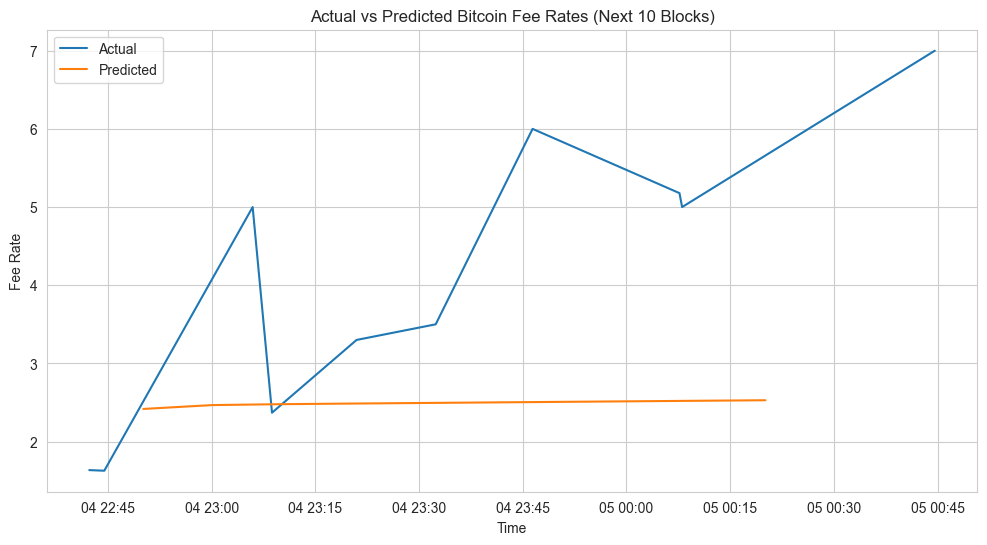

In [7]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time

start=time.time()

df = pd.read_csv('real_time_cleaned.csv')
df['block_time'] = pd.to_datetime(df['block_time'])
df = df.sort_values('block_time')

# Prepare data for Prophet
prophet_df = df[['block_time', 'block_median_fee_rate']].rename(columns={'block_time': 'ds', 'block_median_fee_rate': 'y'})

# Add essential features
prophet_df['hour'] = prophet_df['ds'].dt.hour
prophet_df['day_of_week'] = prophet_df['ds'].dt.dayofweek
prophet_df['is_weekend'] = prophet_df['day_of_week'].isin([5, 6]).astype(int)
prophet_df['fee_lag_1'] = prophet_df['y'].shift(1)
prophet_df['tx_count'] = df['tx_count']
prophet_df['mempool_size_mb'] = df['mempool_size_mb']
prophet_df['hash_rate'] = df['hash_rate']
prophet_df['avg_fee_rate'] = df['avg_fee_rate']
prophet_df['bitcoin_price_usd'] = df['bitcoin_price_usd']
prophet_df['block_height'] = df['block_height']
prophet_df['max_fee_rate'] = df['max_fee_rate']
prophet_df['difficulty'] = df['difficulty']
prophet_df['block_weight'] = df['block_weight']
prophet_df['block_version'] = df['block_version']
prophet_df['mempool_usage'] = df['mempool_usage']

# Remove rows with NaN values (since lagged features are introduced)
prophet_df = prophet_df.dropna()

# Split data for training
train_size = len(prophet_df) - 10  # Change here to 10 if want to predict next 10 blocks
train_df = prophet_df[:train_size]

# Create and fit Prophet model
model = Prophet(
    changepoint_prior_scale=2.0,  # Increased to better capture abrupt changes
    seasonality_prior_scale=10,   # Adjusted for better seasonality flexibility
    holidays_prior_scale=5,
    daily_seasonality=False,      # Removed daily seasonality
    weekly_seasonality=False,     # Custom weekly seasonality will be added
    yearly_seasonality=False,
    seasonality_mode='additive'
)

# Add custom seasonalities
model.add_seasonality(name='weekly', period=7, fourier_order=3)  # Reduced fourier order to avoid overfitting

# Add regressors
regressors = ['hour', 'day_of_week', 'is_weekend', 'fee_lag_1', 'tx_count', 'mempool_size_mb', 'hash_rate', 'avg_fee_rate', 'bitcoin_price_usd', 'block_height', 'max_fee_rate', 'difficulty', 'block_weight', 'block_version', 'mempool_usage']


for regressor in regressors:
    model.add_regressor(regressor)

# Fit the model on the training data
model.fit(train_df)

# Start recursive prediction for the next 144 blocks
last_known_data = train_df.copy().iloc[-1]
future_predictions = []

for i in range(10):# Change here to 10 if want to predict next 10 blocks
    # Prepare the data for the next prediction
    next_input = pd.DataFrame([last_known_data[['ds'] + regressors].fillna(0)])
    future = model.predict(next_input)
    yhat = future['yhat'].values[0]
    
    # Append the prediction to the list of predictions
    future_predictions.append({'ds': last_known_data['ds'] + pd.Timedelta(minutes=10), 'y': yhat})  # Assuming 10-minute intervals

    # Update the features using the predicted value
    new_data = last_known_data.copy()
    new_data['ds'] = new_data['ds'] + pd.Timedelta(minutes=10)
    new_data['y'] = yhat
    new_data['fee_lag_1'] = yhat
    new_data['tx_count'] = last_known_data['tx_count']  # Replace with predicted or estimated value if available
    new_data['mempool_size_mb'] = last_known_data['mempool_size_mb']
    new_data['hash_rate'] = last_known_data['hash_rate']
    new_data['avg_fee_rate'] = last_known_data['avg_fee_rate']
    new_data['bitcoin_price_usd'] = last_known_data['bitcoin_price_usd']
    new_data['block_height'] = last_known_data['block_height']
    new_data['max_fee_rate'] = last_known_data['max_fee_rate']
    new_data['difficulty'] = last_known_data['difficulty']
    new_data['block_weight'] = last_known_data['block_weight']
    new_data['block_version'] = last_known_data['block_version']
    new_data['mempool_usage'] = last_known_data['mempool_usage']

    # Update the last known data for the next iteration
    last_known_data = new_data

# Convert future predictions to a DataFrame
future_predictions_df = pd.DataFrame(future_predictions)

# Ensure y_true and y_pred have the same length
y_pred = future_predictions_df['y'].values
y_true = prophet_df['y'][-len(y_pred):].values

# Remove any NaNs from the evaluation data
y_true = y_true[~np.isnan(y_true)]
y_pred = y_pred[~np.isnan(y_pred)]

# Ensure y_true and y_pred are still consistent in length
y_true = y_true[:len(y_pred)]
y_pred = y_pred[:len(y_true)]

# Evaluate the model
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

def theil_u(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the percent changes
    y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
    y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]  # Use y_true[:-1] as the base for both
    
    # Calculate Theil's U statistic
    numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
    denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
    
    return numerator / denominator
end=time.time()
mape = mean_absolute_percentage_error(y_true, y_pred)
da = directional_accuracy(y_true, y_pred)
theils_u = theil_u(y_true, y_pred)
print("\nProphet Model Performance for Next 10 Blocks:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2}")
print(f"MAPE: {mape:.4f}%")
print(f"Directional Accuracy: {da:.4f}%")
print(f"Theil's U Statistic: {theils_u:.4f}")
print(f"Training time: {end-start}s")

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(prophet_df['ds'][-len(y_true):], y_true, label='Actual')
plt.plot(future_predictions_df['ds'][:len(y_pred)], y_pred, label='Predicted')
plt.title('Actual vs Predicted Bitcoin Fee Rates (Next 10 Blocks)')
plt.xlabel('Time')
plt.ylabel('Fee Rate')
plt.legend()
plt.show()

In [6]:
df.shape

(2632, 26)